In [1]:
import time
import numpy as np
import datajoint as dj
import networkx as nx

import matplotlib.pyplot as plt #for graph visualization

In [2]:
#configure datajoint access to skeletons
pinky = dj.create_virtual_module("pinky","microns_pinky")

Connecting celiib@10.28.0.34:3306


In [3]:
"""  Datajoint example by just picking a random one"""
#just gets the ids and the edges
neurite_skeletons = (dj.U("segment_id","edges") 
                     & pinky.NeuriteSkeleton).fetch(
                        as_dict=True)

#process Example of the filtered skeletons
example_skeleton = neurite_skeletons[2]
example_skeleton

OrderedDict([('segment_id', 648518346341351508),
             ('edges', array([[[332814.  , 278125.  ,   1359.88],
                      [332450.  , 277929.  ,   1604.  ]],
              
                     [[332450.  , 277929.  ,   1604.  ],
                      [332078.  , 277740.  ,   1835.09]],
              
                     [[332078.  , 277740.  ,   1835.09],
                      [331755.  , 277596.  ,   2052.46]],
              
                     ...,
              
                     [[259241.  , 280289.  ,  14176.6 ],
                      [258802.  , 280141.  ,  14470.8 ]],
              
                     [[258802.  , 280141.  ,  14470.8 ],
                      [258306.  , 279918.  ,  15001.2 ]],
              
                     [[258306.  , 279918.  ,  15001.2 ],
                      [257855.  , 279585.  ,  15520.9 ]]]))])

In [10]:
"""  Example skeleton that is disconnected """
example_edges = np.array([[[0,0,0],[1,0,0]],
                          [[1,0,0],[1,2,0]],
                          [[1,2,0],[0,3,0]],
                          [[0,4,0],[0,4,1]],
                          [[0,4,1],[0,5,2]],
                          [[0,5,2],[0,6,-1]],
                          [[0,6,0.5],[0,15,5]],
                          [[0,15,5],[100,100,1]]
                          
                          
                         ])

example_edges
example_skeleton = dict(segment_id=1,
                       edges =example_edges,
                       )

In [11]:


#unpacks so just list of vertices
vertices_unpacked  = example_skeleton["edges"].reshape(-1,3)

#reduce the number of repeat vertices and convert to list
unique_rows = np.unique(vertices_unpacked, axis=0)
unique_rows_list = unique_rows.tolist()

#assigns the number to the vertex (in the original vertex list) that corresponds to the index in the unique list
vertices_unpacked_coefficients = [unique_rows_list.index(a) for a in vertices_unpacked.tolist()]

#reshapes the vertex list to become an edge list
edges_with_coefficients =  np.array(vertices_unpacked_coefficients).reshape(-1,2)
len(edges_with_coefficients),len(example_skeleton["edges"])
edges_with_coefficients


#create the graph from the edges
B = nx.Graph()
B.add_nodes_from([(x,{"coordinates":y}) for x,y in enumerate(unique_rows_list)])
B.add_edges_from(edges_with_coefficients)
# #possible_segmentations = [n for n,x in B.degree() if x > 3]
# #possible_segmentations

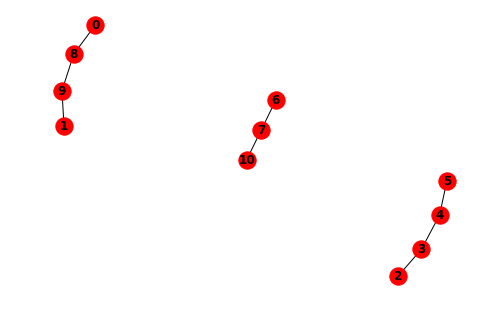

In [12]:
nx.draw(B,with_labels=True,font_weight="bold")
plt.show()


In [13]:
#get the subgraphs of the network
B.subgraph

# make an undirected copy of the digraph
UG = B.to_undirected()

# extract subgraphs
sub_graphs = nx.connected_component_subgraphs(UG)

for i, sg in enumerate(sub_graphs):
    print("subgraph {} has {} nodes".format(i, sg.number_of_nodes()))
    print("\tNodes:", sg.nodes(data=True))
    print("\tEdges:", sg.edges())


subgraph 0 has 4 nodes
	Nodes: [(0, {'coordinates': [0.0, 0.0, 0.0]}), (8, {'coordinates': [1.0, 0.0, 0.0]}), (9, {'coordinates': [1.0, 2.0, 0.0]}), (1, {'coordinates': [0.0, 3.0, 0.0]})]
	Edges: [(0, 8), (8, 9), (9, 1)]
subgraph 1 has 4 nodes
	Nodes: [(2, {'coordinates': [0.0, 4.0, 0.0]}), (3, {'coordinates': [0.0, 4.0, 1.0]}), (4, {'coordinates': [0.0, 5.0, 2.0]}), (5, {'coordinates': [0.0, 6.0, -1.0]})]
	Edges: [(2, 3), (3, 4), (4, 5)]
subgraph 2 has 3 nodes
	Nodes: [(10, {'coordinates': [100.0, 100.0, 1.0]}), (6, {'coordinates': [0.0, 6.0, 0.5]}), (7, {'coordinates': [0.0, 15.0, 5.0]})]
	Edges: [(10, 7), (6, 7)]


In [14]:
"""
Pseudo code on how to stitch back neurons:
For each of the subgraphs, iterate through all other subgraphs:
1) 


Option 1: 
1) Divide graph into subgraphs
2) Find an edge that connects the first subgraph to another subgraph
3) Add the edge to the biggest graph
4) Get all the subgraphs again
5) If only 1 then break out of loop, or else continue


"""

'\nPseudo code on how to stitch back neurons:\nFor each of the subgraphs, iterate through all other subgraphs:\n1) \n\n\nOption 1: \n1) Divide graph into subgraphs\n2) Find an edge that connects the first subgraph to another subgraph\n3) Add the edge to the biggest graph\n4) Get all the subgraphs again\n5) If only 1 then break out of loop, or else continue\n\n\n'

In [15]:
# find the shortest distance between the two different subgraphs:
from scipy.spatial import distance_matrix

UG = B.to_undirected()

# extract subgraphs
sub_graphs = nx.connected_component_subgraphs(UG)

subgraphs_list = []
for i, sg in enumerate(sub_graphs):
    print("subgraph {} has {} nodes".format(i, sg.number_of_nodes()))
    print("\tNodes:", sg.nodes(data=True))
    print("\tEdges:", sg.edges())
    subgraphs_list.append(sg)

print("len_subgraphs AT BEGINNING = " + str(len(subgraphs_list)))

while len(subgraphs_list) > 1:
    current_sub_graph = subgraphs_list[0]
    #get all of the coordinates of this subgraph 
    coord = nx.get_node_attributes(current_sub_graph,'coordinates')
    current_nodes = np.array(list(current_sub_graph.nodes))
    current_coordinates = np.array(list(coord.values()))
    
    #store the minimum distance
    min_dist = np.inf
    min_dist_subgraph_index = -1
    min_dist_edge = [-1,-1]
    min_dist_edge_index = [-1,-1]
    
    #i = 0
    for i, sg in enumerate(subgraphs_list):
        if i == 0:
            continue
        
        
        #get all of the coordinates
        new_coord = nx.get_node_attributes(sg,'coordinates')
        new_coordinates = np.array(list(new_coord.values()))
        new_nodes = np.array(list(sg.nodes))
        
        #find the closest distance between those points
        a_New = current_coordinates
        b_New = new_coordinates
        
        # print("starting distance matrix")
        start_time = time.time()

        a_b_distance = distance_matrix(a_New, b_New)
        print(a_b_distance)
        
        current_min = np.min(a_b_distance)
        dist_matrix_index = np.where(a_b_distance == current_min)
        min_indexes = dist_matrix_index[0][0],dist_matrix_index[1][0]
        
        print("Min indexes = " + str(min_indexes))
        
        if current_min<min_dist:
            min_dist = current_min
            min_dist_subgraph_index = i
            min_dist_edge_index = [current_nodes[min_indexes[0]],
                                   new_nodes[min_indexes[1]]]
            min_dist_edge = [current_coordinates[min_indexes[0]],
                                    new_coordinates[min_indexes[1]]]
        #i += 1
    
    #add the shortest connection to the overall edges
    print("min_dist = " + str(min_dist))
    print("min_dist_subgraph_index = " + str(min_dist_subgraph_index))
    print("min_dist_edge_index = " + str(min_dist_edge_index))
    print("min_dist_edge = " + str(min_dist_edge))
    
    #adds the new edge to the graph
    B.add_edge(*min_dist_edge_index)
    
    #
    print("edges after adding")
    print(B.edges())
    UG = B.to_undirected()

    # extract subgraphs
    sub_graphs = nx.connected_component_subgraphs(UG)
    subgraphs_list = []
    for i, sg in enumerate(sub_graphs):
        print("subgraph {} has {} nodes".format(i, sg.number_of_nodes()))
        print("\tNodes:", sg.nodes(data=True))
        print("\tEdges:", sg.edges())
        subgraphs_list.append(sg)

    print("len_subgraphs AT END= " + str(len(subgraphs_list)))



subgraph 0 has 4 nodes
	Nodes: [(0, {'coordinates': [0.0, 0.0, 0.0]}), (8, {'coordinates': [1.0, 0.0, 0.0]}), (9, {'coordinates': [1.0, 2.0, 0.0]}), (1, {'coordinates': [0.0, 3.0, 0.0]})]
	Edges: [(0, 8), (8, 9), (9, 1)]
subgraph 1 has 4 nodes
	Nodes: [(2, {'coordinates': [0.0, 4.0, 0.0]}), (3, {'coordinates': [0.0, 4.0, 1.0]}), (4, {'coordinates': [0.0, 5.0, 2.0]}), (5, {'coordinates': [0.0, 6.0, -1.0]})]
	Edges: [(2, 3), (3, 4), (4, 5)]
subgraph 2 has 3 nodes
	Nodes: [(10, {'coordinates': [100.0, 100.0, 1.0]}), (6, {'coordinates': [0.0, 6.0, 0.5]}), (7, {'coordinates': [0.0, 15.0, 5.0]})]
	Edges: [(10, 7), (6, 7)]
len_subgraphs AT BEGINNING = 3
[[4.         4.12310563 5.38516481 6.08276253]
 [4.12310563 4.24264069 5.47722558 6.164414  ]
 [2.23606798 2.44948974 3.74165739 4.24264069]
 [1.         1.41421356 2.82842712 3.16227766]]
Min indexes = (3, 0)
[[141.42489173   6.02079729  15.8113883 ]
 [140.71957931   6.10327781  15.84297952]
 [139.30541985   4.15331193  13.96424004]
 [139.319

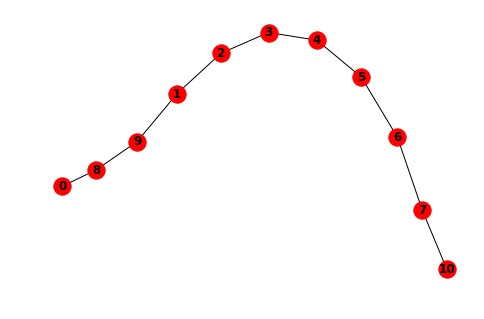

In [17]:
nx.draw(B,with_labels=True,font_weight="bold")
plt.show()

# End of neuron stitching algorithm

# Start function that will stitch a neuron

In [24]:
def stitch_skeleton(staring_edges):
    

    #unpacks so just list of vertices
    vertices_unpacked  = example_skeleton["edges"].reshape(-1,3)

    #reduce the number of repeat vertices and convert to list
    unique_rows = np.unique(vertices_unpacked, axis=0)
    unique_rows_list = unique_rows.tolist()

    #assigns the number to the vertex (in the original vertex list) that corresponds to the index in the unique list
    vertices_unpacked_coefficients = [unique_rows_list.index(a) for a in vertices_unpacked.tolist()]

    #reshapes the vertex list to become an edge list
    edges_with_coefficients =  np.array(vertices_unpacked_coefficients).reshape(-1,2)
    
    #create the graph from the edges
    B = nx.Graph()
    B.add_nodes_from([(x,{"coordinates":y}) for x,y in enumerate(unique_rows_list)])
    B.add_edges_from(edges_with_coefficients)

    # find the shortest distance between the two different subgraphs:
    from scipy.spatial import distance_matrix

    UG = B.to_undirected()

    # extract subgraphs
    sub_graphs = nx.connected_component_subgraphs(UG)

    subgraphs_list = []
    for i, sg in enumerate(sub_graphs):
        #print("subgraph {} has {} nodes".format(i, sg.number_of_nodes()))
        #print("\tNodes:", sg.nodes(data=True))
        #print("\tEdges:", sg.edges())
        subgraphs_list.append(sg)

    print("len_subgraphs AT BEGINNING = " + str(len(subgraphs_list)))

    while len(subgraphs_list) > 1:
        current_sub_graph = subgraphs_list[0]
        #get all of the coordinates of this subgraph 
        coord = nx.get_node_attributes(current_sub_graph,'coordinates')
        current_nodes = np.array(list(current_sub_graph.nodes))
        current_coordinates = np.array(list(coord.values()))

        #store the minimum distance
        min_dist = np.inf
        min_dist_subgraph_index = -1
        min_dist_edge = [-1,-1]
        min_dist_edge_index = [-1,-1]

        #i = 0
        for i, sg in enumerate(subgraphs_list):
            if i == 0:
                continue


            #get all of the coordinates
            new_coord = nx.get_node_attributes(sg,'coordinates')
            new_coordinates = np.array(list(new_coord.values()))
            new_nodes = np.array(list(sg.nodes))

            #find the closest distance between those points
            a_New = current_coordinates
            b_New = new_coordinates

            # print("starting distance matrix")
            start_time = time.time()

            a_b_distance = distance_matrix(a_New, b_New)
            #print(a_b_distance)

            current_min = np.min(a_b_distance)
            dist_matrix_index = np.where(a_b_distance == current_min)
            min_indexes = dist_matrix_index[0][0],dist_matrix_index[1][0]

            #print("Min indexes = " + str(min_indexes))

            if current_min<min_dist:
                min_dist = current_min
                min_dist_subgraph_index = i
                min_dist_edge_index = [current_nodes[min_indexes[0]],
                                       new_nodes[min_indexes[1]]]
                min_dist_edge = [current_coordinates[min_indexes[0]],
                                        new_coordinates[min_indexes[1]]]
            #i += 1

        #add the shortest connection to the overall edges
        print("min_dist = " + str(min_dist))
        print("min_dist_subgraph_index = " + str(min_dist_subgraph_index))
        print("min_dist_edge_index = " + str(min_dist_edge_index))
        print("min_dist_edge = " + str(min_dist_edge))

        #adds the new edge to the graph
        B.add_edge(*min_dist_edge_index)

        #
        print("edges after adding")
        print(B.edges())
        UG = B.to_undirected()

        # extract subgraphs
        sub_graphs = nx.connected_component_subgraphs(UG)
        subgraphs_list = []
        for i, sg in enumerate(sub_graphs):
#             print("subgraph {} has {} nodes".format(i, sg.number_of_nodes()))
#             print("\tNodes:", sg.nodes(data=True))
#             print("\tEdges:", sg.edges())
            subgraphs_list.append(sg)

        print("len_subgraphs AT END= " + str(len(subgraphs_list)))
        
    #add all the new edges to the 

    total_coord = nx.get_node_attributes(B,'coordinates')
    current_coordinates = np.array(list(total_coord.values()))
    return current_coordinates[B.edges()]




In [25]:
"""  Example skeleton that is disconnected """
example_edges = np.array([[[0,0,0],[1,0,0]],
                          [[1,0,0],[1,2,0]],
                          [[1,2,0],[0,3,0]],
                          [[0,4,0],[0,4,1]],
                          [[0,4,1],[0,5,2]],
                          [[0,5,2],[0,6,-1]],
                          [[0,6,0.5],[0,15,5]],
                          [[0,15,5],[100,100,1]]
                          
                          
                         ])

example_edges
example_skeleton = dict(segment_id=1,
                       edges =example_edges,
                       )

start_time = time.time()
new_skeleton = stitch_skeleton(example_skeleton["edges"])
print(new_skeleton)
print("Total time = " + str(time.time() - start_time))


len_subgraphs AT BEGINNING = 3
min_dist = 1.0
min_dist_subgraph_index = 1
min_dist_edge_index = [1, 2]
min_dist_edge = [array([0., 3., 0.]), array([0., 4., 0.])]
edges after adding
[(0, 8), (1, 9), (1, 2), (2, 3), (3, 4), (4, 5), (6, 7), (7, 10), (8, 9)]
len_subgraphs AT END= 2
min_dist = 1.5
min_dist_subgraph_index = 1
min_dist_edge_index = [5, 6]
min_dist_edge = [array([ 0.,  6., -1.]), array([0. , 6. , 0.5])]
edges after adding
[(0, 8), (1, 9), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 10), (8, 9)]
len_subgraphs AT END= 1
[[[  0.    0.    0. ]
  [  1.    0.    0. ]]

 [[  0.    3.    0. ]
  [  1.    2.    0. ]]

 [[  0.    3.    0. ]
  [  0.    4.    0. ]]

 [[  0.    4.    0. ]
  [  0.    4.    1. ]]

 [[  0.    4.    1. ]
  [  0.    5.    2. ]]

 [[  0.    5.    2. ]
  [  0.    6.   -1. ]]

 [[  0.    6.   -1. ]
  [  0.    6.    0.5]]

 [[  0.    6.    0.5]
  [  0.   15.    5. ]]

 [[  0.   15.    5. ]
  [100.  100.    1. ]]

 [[  1.    0.    0. ]
  [  1.    2.    0. ]]]

In [34]:

new_nodes = np.array([x for x,n in B.degree() if n <= 1])
new_coord = nx.get_node_attributes(B,'coordinates')
new_coordinates = np.array(list(new_coord.values()))[new_nodes]
new_coordinates


array([[  0.,   0.,   0.],
       [100., 100.,   1.]])

# Stitching Method with degree check

In [50]:
"""
Stitching that allows you to specify number the degree of the 
node that are eligible to be stitched back

"""

def stitch_skeleton_with_degree_check(staring_edges,end_node=False):
    

    #unpacks so just list of vertices
    vertices_unpacked  = example_skeleton["edges"].reshape(-1,3)

    #reduce the number of repeat vertices and convert to list
    unique_rows = np.unique(vertices_unpacked, axis=0)
    unique_rows_list = unique_rows.tolist()

    #assigns the number to the vertex (in the original vertex list) that corresponds to the index in the unique list
    vertices_unpacked_coefficients = [unique_rows_list.index(a) for a in vertices_unpacked.tolist()]

    #reshapes the vertex list to become an edge list
    edges_with_coefficients =  np.array(vertices_unpacked_coefficients).reshape(-1,2)
    
    #create the graph from the edges
    B = nx.Graph()
    B.add_nodes_from([(x,{"coordinates":y}) for x,y in enumerate(unique_rows_list)])
    B.add_edges_from(edges_with_coefficients)

    # find the shortest distance between the two different subgraphs:
    from scipy.spatial import distance_matrix

    UG = B.to_undirected()

    # extract subgraphs
    sub_graphs = nx.connected_component_subgraphs(UG)

    subgraphs_list = []
    for i, sg in enumerate(sub_graphs):
        #print("subgraph {} has {} nodes".format(i, sg.number_of_nodes()))
        #print("\tNodes:", sg.nodes(data=True))
        #print("\tEdges:", sg.edges())
        subgraphs_list.append(sg)

    print("len_subgraphs AT BEGINNING = " + str(len(subgraphs_list)))

    while len(subgraphs_list) > 1:
        current_sub_graph = subgraphs_list[0]
        #get all of the coordinates of this subgraph 
        #get all of the coordinates
        if end_node == True:
            current_nodes = np.array([x for x,n in current_sub_graph.degree() if n <= 1])
            current_coord = nx.get_node_attributes(current_sub_graph,'coordinates')
            current_coord_filter = { k:v for k,v in current_coord.items() if k in  current_nodes}
            current_coordinates = np.array(list(current_coord_filter.values()))
        
        else:
            #get all of the coordinates
            current_nodes = np.array(list(current_sub_graph.nodes))
            current_coord = nx.get_node_attributes(current_sub_graph,'coordinates')
            current_coordinates = np.array(list(current_coord.values()))
            
#         coord = nx.get_node_attributes(current_sub_graph,'coordinates')
#         current_nodes = np.array(list(current_sub_graph.nodes))
#         current_coordinates = np.array(list(coord.values()))

        #store the minimum distance
        min_dist = np.inf
        min_dist_subgraph_index = -1
        min_dist_edge = [-1,-1]
        min_dist_edge_index = [-1,-1]

        #i = 0
        for i, sg in enumerate(subgraphs_list):
            if i == 0:
                continue

            #get all of the coordinates
            if end_node == True:
                new_nodes = np.array([x for x,n in sg.degree() if n <= 1])
                #print("new nodes = " + str(new_nodes))
                new_coord = nx.get_node_attributes(sg,'coordinates')
                #print("new_coord = " + str(new_coord))
                new_coord_filter = { k:v for k,v in new_coord.items() if k in  new_nodes}
                new_coordinates = np.array(list(new_coord_filter.values()))
            else:
                #get all of the coordinates
                new_nodes = np.array(list(sg.nodes))
                new_coord = nx.get_node_attributes(sg,'coordinates')
                new_coordinates = np.array(list(new_coord.values()))
                
            #find the closest distance between those points
            a_New = current_coordinates
            b_New = new_coordinates

            # print("starting distance matrix")
            start_time = time.time()

            a_b_distance = distance_matrix(a_New, b_New)
            #print(a_b_distance)

            current_min = np.min(a_b_distance)
            dist_matrix_index = np.where(a_b_distance == current_min)
            min_indexes = dist_matrix_index[0][0],dist_matrix_index[1][0]

            #print("Min indexes = " + str(min_indexes))

            if current_min<min_dist:
                min_dist = current_min
                min_dist_subgraph_index = i
                min_dist_edge_index = [current_nodes[min_indexes[0]],
                                       new_nodes[min_indexes[1]]]
                min_dist_edge = [current_coordinates[min_indexes[0]],
                                        new_coordinates[min_indexes[1]]]
            #i += 1

        #add the shortest connection to the overall edges
        print("min_dist = " + str(min_dist))
        print("min_dist_subgraph_index = " + str(min_dist_subgraph_index))
        print("min_dist_edge_index = " + str(min_dist_edge_index))
        print("min_dist_edge = " + str(min_dist_edge))

        #adds the new edge to the graph
        B.add_edge(*min_dist_edge_index)

        #
        print("edges after adding")
        print(B.edges())
        UG = B.to_undirected()

        # extract subgraphs
        sub_graphs = nx.connected_component_subgraphs(UG)
        subgraphs_list = []
        for i, sg in enumerate(sub_graphs):
#             print("subgraph {} has {} nodes".format(i, sg.number_of_nodes()))
#             print("\tNodes:", sg.nodes(data=True))
#             print("\tEdges:", sg.edges())
            subgraphs_list.append(sg)

        print("len_subgraphs AT END= " + str(len(subgraphs_list)))
        
    #add all the new edges to the 

    total_coord = nx.get_node_attributes(B,'coordinates')
    current_coordinates = np.array(list(total_coord.values()))
    return current_coordinates[B.edges()]




In [49]:


"""  Example skeleton that is disconnected """
example_edges = np.array([
                          [[0,0,0],[1,0,0]],
                          [[1,0,0],[1,2,0]],
                          [[1,2,0],[0,3,0]],
                          [[0,4,0],[0,4,1]],
                          [[0,4,1],[0,5,2]],
                          [[0,5,2],[0,6,-1]],
                          [[200,200,0.5],[0,6,0.5]],
                          [[0,6,0.5],[0,15,5]],
                          [[0,15,5],[100,100,1]]
                          
                          
                         ])

example_edges
example_skeleton = dict(segment_id=1,
                       edges =example_edges,
                       )

start_time = time.time()
new_skeleton = stitch_skeleton_with_degree_check(example_skeleton["edges"],end_node=True)
print(new_skeleton)
print("Total time = " + str(time.time() - start_time))


len_subgraphs AT BEGINNING = 3
min_dist = 1.0
min_dist_subgraph_index = 1
min_dist_edge_index = [1, 2]
min_dist_edge = [array([0., 3., 0.]), array([0., 4., 0.])]
edges after adding
[(0, 8), (1, 9), (1, 2), (2, 3), (3, 4), (4, 5), (6, 11), (6, 7), (7, 10), (8, 9)]
len_subgraphs AT END= 2
min_dist = 137.2588794941879
min_dist_subgraph_index = 1
min_dist_edge_index = [5, 10]
min_dist_edge = [array([ 0.,  6., -1.]), array([100., 100.,   1.])]
edges after adding
[(0, 8), (1, 9), (1, 2), (2, 3), (3, 4), (4, 5), (5, 10), (6, 11), (6, 7), (7, 10), (8, 9)]
len_subgraphs AT END= 1
[[[  0.    0.    0. ]
  [  1.    0.    0. ]]

 [[  0.    3.    0. ]
  [  1.    2.    0. ]]

 [[  0.    3.    0. ]
  [  0.    4.    0. ]]

 [[  0.    4.    0. ]
  [  0.    4.    1. ]]

 [[  0.    4.    1. ]
  [  0.    5.    2. ]]

 [[  0.    5.    2. ]
  [  0.    6.   -1. ]]

 [[  0.    6.   -1. ]
  [100.  100.    1. ]]

 [[  0.    6.    0.5]
  [200.  200.    0.5]]

 [[  0.    6.    0.5]
  [  0.   15.    5. ]]

 [[  0. 

In [ ]:

# #
# UG = B.to_undirected()

# # extract subgraphs
# sub_graphs = nx.connected_component_subgraphs(UG)
# len_subgraphs = 0
# sub_graphs_list = []
# for sg in sub_graphs:
#     print("subgraph has {} nodes".format(sg.number_of_nodes()))
#     print("\tNodes:", sg.nodes(data=True))
#     print("\tEdges:", sg.edges())
    
#     len_subgraphs += 1
#     sub_graphs_list.append(sg)

In [ ]:
# for i, sg in enumerate(sub_graphs_list):
#     print("subgraph {} has {} nodes".format(i, sg.number_of_nodes()))
#     print("\tNodes:", sg.nodes(data=True))
#     print("\tEdges:", sg.edges())
#     len_subgraphs += 1

In [ ]:
# 1000000 < np.inf

In [ ]:
from scipy.spatial import distance_matrix

a_New = np.array([[1,3],[60,70],[4,5]])
b_New = np.array([[10,3],[4,6]])
start_time = time.time()

print(len(a_New),len(b_New))
#         print("starting distance matrix")
start_time = time.time()

a_b_distance = distance_matrix(a_New, b_New)
print(a_b_distance)

In [ ]:
dist_matrix_index = np.where(a_b_distance == np.min(a_b_distance))
min_indexes = dist_matrix_index[0][0],dist_matrix_index[1][0]
min_indexes

In [ ]:
help(distance_matrix)

In [ ]:
np.linalg.norm((a_New[0],b_New[0]))

In [ ]:
# How to get all of the coordinates of a certain subgraph

coordinates=nx.get_node_attributes(UG,'coordinates')

In [ ]:
np.array(list(coordinates.values()))

In [ ]:
help(np.linalg.norm)

In [ ]:
node_1_xyz = np.array(B.nodes[0]["coordinates"])
node_2_xyz = np.array(B.nodes[1]["coordinates"])

dist = np.linalg.norm(node_1_xyz-node_2_xyz)
print(dist)
threshold = 1500
if dist < threshold:
    print("too close")

In [ ]:
from tqdm import tqdm
possible_error_neurites = []

for skeleton in tqdm(neurite_skeletons):
    #print(str(skeleton['segment_id']) + ":")
    
    vertices_unpacked  = skeleton["edges"].reshape(-1,3)
    if not vertices_unpacked.any():
        continue
    #reduce the 
    unique_rows = np.unique(vertices_unpacked, axis=0)
    unique_rows_list = unique_rows.tolist()
    #assigns the number to the vertex that corresponds to the index in the unique list
    vertices_unpacked_coefficients = [unique_rows_list.index(a) for a in vertices_unpacked.tolist()]
    edges_with_coefficients =  np.array(vertices_unpacked_coefficients).reshape(-1,2)
    #len(edges_with_coefficients),len(example_skeleton["edges"])
    
    B = nx.Graph()
    B.add_nodes_from([(x,{"coordinates":y}) for x,y in enumerate(unique_rows_list)])
    B.add_edges_from(edges_with_coefficients)
    possible_segmentations = [n for n,x in B.degree() if x > 3]
    if len(possible_segmentations) > 0:
        possible_error_neurites.append({skeleton['segment_id']:len(possible_segmentations)})
          
          
    

In [ ]:
print(len(neurite_skeletons),len(possible_error_neurites))

In [ ]:
4590/32234

In [ ]:
from tqdm import tqdm
possible_error_neurites_2 = []

tree_threshold = 50

for skeleton in tqdm(neurite_skeletons):
    #print(str(skeleton['segment_id']) + ":")
    
    vertices_unpacked  = skeleton["edges"].reshape(-1,3)
    if not vertices_unpacked.any():
        continue
    #reduce the 
    unique_rows = np.unique(vertices_unpacked, axis=0)
    unique_rows_list = unique_rows.tolist()
    #assigns the number to the vertex that corresponds to the index in the unique list
    vertices_unpacked_coefficients = [unique_rows_list.index(a) for a in vertices_unpacked.tolist()]
    edges_with_coefficients =  np.array(vertices_unpacked_coefficients).reshape(-1,2)
    #len(edges_with_coefficients),len(example_skeleton["edges"])
    
    B = nx.Graph()
    B.add_nodes_from([(x,{"coordinates":y}) for x,y in enumerate(unique_rows_list)])
    B.add_edges_from(edges_with_coefficients)
    possible_segmentations_4 = [n for n,x in B.degree() if x > 3]
    if len(possible_segmentations_4) > 0:
        possible_error_neurites_2.append({skeleton['segment_id']:"4 split"})
        
    else:
        possible_segmentations_3 = [n for n,x in B.degree() if x > 2]
        
        
        if len(possible_segmentations_3) > 1:
            break_Flag = False
            for ps in possible_segmentations_3:
                if break_Flag == True:
                    break
                for ps_2 in possible_segmentations_3:
                    if break_Flag == True:
                        break
                    if ps != ps_2:
                        #check the distance of the points
                        node_1_xyz = np.array(B.nodes[ps]["coordinates"])
                        node_2_xyz = np.array(B.nodes[ps_2]["coordinates"])
                        
                        dist = np.linalg.norm(node_1_xyz-node_2_xyz)
                        #print(dist)
                        
                        if dist < tree_threshold:
                            possible_error_neurites_2.append({skeleton['segment_id']:"3 split"})
                            break_Flag = True
                            break
                        
                        
                        
          

In [ ]:

#WITH THRESHOLD = 500
print(len(neurite_skeletons),len(possible_error_neurites),len(possible_error_neurites_2))

In [ ]:
6305/32234

In [ ]:
#examples to plot meshes
possible_error_neurites_2[1]
possible_error_neurites[1]

In [ ]:

#WITH THRESHOLD = 50
print(len(neurite_skeletons),len(possible_error_neurites),len(possible_error_neurites_2))